In [1]:
from igraph import Graph
import numpy as np
import pandas as pd
import igraph
import networkx as nx

In [3]:
nodes=pd.read_csv('Nodes_definitivo.csv')
edges=pd.read_csv('Edges_df6.csv')

In [5]:
nodes["Colour"].unique()
#   @EnricoLetta==#b00b69
#   #NoGreenPass==#fb1239
#   @MatteoSalvinimi==#99cccc
#   @CasaPoundItalia==#042069
#   #Vaccinatevi==#007474

array(['#99cccc', '#b00b69', '#007474', '#042069', '#fb1239'],
      dtype=object)

In [15]:
nodes.groupby("hashtags")["gruppo"].count()

hashtags
#NoGreenPass        1635
#vaccinatevi        1304
@CasaPoundItalia     299
@EnricoLetta        1147
@matteosalvinimi    1249
Name: gruppo, dtype: int64

In [20]:
nodes[nodes["Giant_Component"]==1].groupby("hashtags")["gruppo"].count()

hashtags
#NoGreenPass        1545
#vaccinatevi        1205
@CasaPoundItalia     297
@EnricoLetta         975
@matteosalvinimi    1168
Name: gruppo, dtype: int64

#### Individuiamo il Giant Component

In [4]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [5]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [6]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [143]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

'Clustering with 5190 elements and 2 clusters'

In [144]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

<AxesSubplot:>

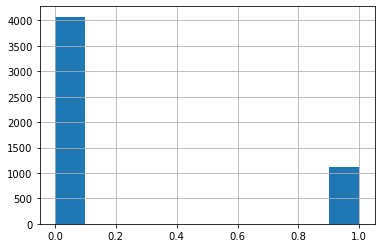

In [145]:
df_eigen["clusters"].hist()

In [146]:
df_eigen.groupby("clusters")["clusters"].count()

clusters
0    4073
1    1117
Name: clusters, dtype: int64

In [147]:
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [148]:
color_clusters(df_eigen,'clusters','cluster_eigen')

In [8]:
#clusters=list(set(df_eigen.clusters))
#nodes['Cluster_eigen']=0
#
#colour=[]
#for index, row in df_eigen.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        for cluster in clusters:
#            if row['clusters']==cluster:
#                nodes.at[sub_index,'Cluster_eigen']=cluster+1
#    else:
#        continue

In [3]:
#utile solo nel caso che il dataframe di partenza presenti gli hex colors invece dei cluster

#for i,r in dummy.iterrows():
#    if r['Colour']=='#aaaacc':
#        dummy.at[i,'Colour']=0
#    if r['Colour']=='#007474':
#        dummy.at[i,'Colour']=1
#    if r['Colour']=='#fb1239':
#        dummy.at[i,'Colour']=2

#### Creazione indice e applicazione k-means

In [149]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [150]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [29]:
adj=nx.adjacency_matrix(G_directed)
from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000).fit(adj)

In [30]:
kmeans2=pd.DataFrame({"gruppo":kmeans2.labels_})

In [31]:
kmeans2.groupby("gruppo")["gruppo"].count()

gruppo
0    4110
1    1080
Name: gruppo, dtype: int64

In [151]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [152]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

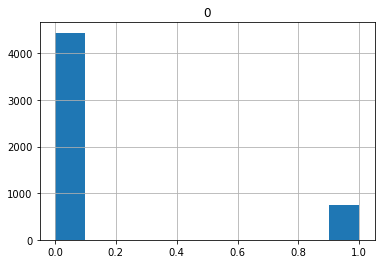

In [153]:
pd.DataFrame(kmeans.labels_).hist()

In [154]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [155]:
color_clusters(df_means,'clusters','cluster_kmeans')

In [378]:
#nodes['Colour']='#aaaacc'
#
#colour=[]
#for index, row in df_means.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        if row['clusters']==0:
#            nodes.at[sub_index,'Colour']='1'
#        if row['clusters']==1:
#            nodes.at[sub_index,'Colour']='2'
#    else:
#        continue

#### Girvan-Newman

In [160]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [161]:
new_G=new_G.to_undirected()

In [162]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [163]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [164]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [8]:
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

NameError: name 'node_groups' is not defined

In [3]:
dummy["Colour"].unique()

NameError: name 'dummy' is not defined

In [181]:
nodes.to_csv("nodes_df6_tot.csv", index=False)

In [4]:
nodes["Colour_GN"].unique()

NameError: name 'nodes' is not defined

#### Valutazione Grafo

In [5]:
import scipy.stats as stats

In [9]:
G_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.DiGraph())

In [11]:
len(G_directed.nodes)

5190

In [106]:
G_multi_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.MultiDiGraph())

In [107]:
#creazione grafo in networkx della Giant Component
G_nx=nx.from_pandas_edgelist(new_edges,source='Source',target='Target')

Assortativity

In [108]:
#Assortativity per intero grafo
#nx.degree_assortativity_coefficient(g_nx)
Assortativity=nx.degree_pearson_correlation_coefficient(g_nx) #più veloce
Assortativity

-0.2152581913514963

In [110]:
#Assortativity per la sola giant component
nx.degree_pearson_correlation_coefficient(G_directed)

-0.20792062392886407

La nostra rete è quindi disassortativa:
- Hubs tend to connect to small nodes.
- Disassortative networks have difficulty forming a giant
component (ops? ahahah)
- Hub removal is more damaging in disassortative networks, as in these the
hubs connect to many small-degree nodes, which fall off the network
once a hub is deleted.

Altri indici

In [37]:
#nx.degree_mixing_dict(g_nx) #cos'è??

In [112]:
#Structural cohesion:
# Connectivity measures the minimum number of elements (vertices or edges) that must be removed to 
# disconnect the graph
# edge connectivity
print(nx.edge_connectivity(g_nx))
print(nx.edge_connectivity(G_nx))
print(nx.edge_connectivity(G_directed))

0
1
0


In [113]:
#node connectivity
print(nx.node_connectivity(g_nx))
print(nx.node_connectivity(G_nx))
print(nx.node_connectivity(G_directed))

0
1
0


In [114]:
#density
#The density of a graph is a measure of how many ties between actors exist compared to how many 
#ties between actors are possible. A dense graph is a graph in which the number of edges is close 
#to the maximal number of edges. 
#NB: The density is 0 for a graph without edges and 1 for a complete graph
print(nx.density(g_nx))
print(nx.density(G_nx))
print(nx.density(G_directed))
#il nostro grafo è sparso

0.00047724496871439607
0.0005404199115440214
0.000270692672471892


In [117]:
#print(nx.eccentricity(g_nx)) grafo non connesso, non si può calcolare l'eccentricity
# It is defined as the maximum distance of one vertex from other vertex. The maximum distance 
# between a vertex to all other vertices is considered as the eccentricity of the vertex.
eccentricity=nx.eccentricity(G_nx)

In [118]:
#The radius of G is the value of the smallest eccentricity.
nx.radius(G_nx)
#min(eccentricity.values())

7

In [119]:
#The diameter of G is the value of the greatest eccentricity.
nx.diameter(G_nx)
#max(eccentricity.values())

14

In [120]:
#reciprocity is a measure of the likelihood of vertices in a directed network to be mutually 
# linked
overall_reciprocity=nx.overall_reciprocity(G_directed)
overall_reciprocity

# 0 -> non ci sono scambi di retweet?

0.0035665294924554186

Degree Analysis (HUBS & Spamm Users)

In [ ]:
#DEGREE
#Degree is a simple centrality measure that counts how many neighbors a node has. 
# If the network is directed, we have two versions of the measure: 
# in-degree is the number of in-coming links, or the number of predecessor nodes; 
# out-degree is the number of out-going links, or the number of successor nodes.

In [121]:
out_degrees=dict(G_directed.out_degree())
out_degrees_sort=dict(sorted(out_degrees.items(), key=lambda item: item[1], reverse= True))
top5_twitters=pd.DataFrame(list(out_degrees_sort.items())[:5],columns=("id_utente","rt_fatti"))
top5_twitters=pd.merge(top5_twitters,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_twitters.drop("Id",axis=1,inplace=True)
top5_twitters
top5_twitters

,id_utente,rt_fatti,Label
0,366660837,38,_fiorucci
1,810235254870937600,32,ferillo2
2,1174780873075544069,26,rosaroccaforte
3,1042691054,26,MastroRadu
4,2535751839,24,MarySpes


In [122]:
#df dei gradi entranti di ciascun nodo
df_gradi_in=pd.DataFrame(in_degrees.items(),columns=["nodi","grado"])

In [123]:
#distribuzione dei nodi per i 5 gradi più ricorrenti
df_gradi_in.groupby("grado").count().head()

,nodi
grado,
0,3304
1,68
2,37
3,21
4,15


In [124]:
#percentuale di nodi con grado=0 (nessun retweet ricevuto)
round(df_gradi_in[df_gradi_in["grado"]==0]["grado"].count()/df_gradi_in["grado"].count(),4)

0.9368

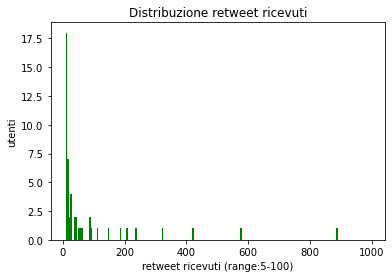

In [ ]:
import matplotlib.pyplot as plt
#distribuzione numero del numero dei retweet ricevuti in un range tra 5 e 100
def plot_in_degree_dist(G):
    bins=np.arange(10,1000,5)  
    degrees = sorted([G.in_degree(n) for n in G.nodes()])
    plt.hist(degrees, bins, color='green')
    plt.ylabel('utenti')
    plt.xlabel('retweet ricevuti (range:5-100)')
    plt.title('Distribuzione retweet ricevuti')
    plt.show()

plot_in_degree_dist(G_directed)

# da questo plot possiamo farci un idea della distribuzione degli hub 
# (nodi con un numero di archi entranti anomalo rispetto al resto della rete )

In [33]:
in_degrees

{442083142: 0,
 1364298062919794688: 1080,
 305255857: 0,
 977383349235961857: 5,
 950098070771036160: 0,
 1438546161955229703: 36,
 229160327: 0,
 1054851091: 0,
 3292300398: 0,
 1272523678140555274: 0,
 1435590896502849538: 0,
 1430162268: 0,
 95106953: 4,
 1396921468127170567: 0,
 1136537422836244480: 10,
 1275154423: 0,
 206832958: 2,
 1017975031: 0,
 2322424306: 29,
 1037003822: 0,
 1425830479006035970: 0,
 2535751839: 0,
 1455070299813257218: 0,
 942266220: 7,
 1063948830: 0,
 1369640371697942528: 0,
 1224287141947232256: 0,
 1392230741875040256: 0,
 757521873743798272: 10,
 416346211: 0,
 1405888434917593098: 0,
 828376782407663617: 0,
 3252394091: 0,
 1168202277091516418: 0,
 1416344428147585025: 0,
 1004766856434110464: 0,
 1349467232: 0,
 1225034977: 0,
 751180558936530944: 1,
 2353382138: 2,
 847096890: 0,
 934809157055799299: 0,
 1052894605: 5,
 2360365059: 1,
 1199127172990021633: 0,
 750752094840320001: 0,
 1090989921454747648: 25,
 1429096741945716741: 0,
 12239544148070

In [32]:
in_degrees=dict(G_directed.in_degree())
in_degrees_sort=dict(sorted(in_degrees.items(), key=lambda item: item[1], reverse= True))
top5_HUBS=pd.DataFrame(list(in_degrees_sort.items())[:5],columns=("id_utente","rt_ricevuti"))
top5_HUBS=pd.merge(top5_HUBS,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_HUBS.drop("Id",axis=1,inplace=True)
top5_HUBS

,id_utente,rt_ricevuti,Label
0,1364298062919794688,1080,Lorenzo62752880
1,22038676,579,mariannaaprile
2,231902290,415,Cartabellotta
3,270839361,332,matteosalvinimi
4,215699843,245,CasaPoundItalia


In [126]:
print(min(in_degrees_sort.values()))
print(max(in_degrees_sort.values()))

0
1080


Centrality

In [127]:
#The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to
#top10 dei nodi con il maggior numero di archi entranti (i più retwettati)--> HUBS
in_degree_centrality=nx.in_degree_centrality(G_directed)
in_degree_centrality_sort=dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_IN_C=list(in_degree_centrality_sort.items())[:10]
top10_IN_C

[(1364298062919794688, 0.20813258816727692),
 (22038676, 0.11158219310079012),
 (231902290, 0.0799768741568703),
 (270839361, 0.06398149932549624),
 (215699843, 0.047215263056465596),
 (1238800491632607232, 0.039892079398728075),
 (4882542093, 0.028521873193293502),
 (1302616789348691968, 0.027943727115051067),
 (419622371, 0.027558296396222776),
 (1434532915417919488, 0.021005974176141837)]

In [128]:
#The out-degree centrality for a node v is the fraction of nodes its outcoming edges are connected to
#top10 dei nodi con il maggior numero di archi uscenti (chi ha retwittato di più)
out_degree_centrality=nx.out_degree_centrality(G_directed)
out_degree_centrality_sort=dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_OUT_C=list(out_degree_centrality_sort.items())[:10]
top10_OUT_C

[(366660837, 0.007323183657737521),
 (810235254870937600, 0.0061668915012526495),
 (1174780873075544069, 0.005010599344767778),
 (1042691054, 0.005010599344767778),
 (2535751839, 0.004625168625939487),
 (358626243, 0.004625168625939487),
 (1382258084567998469, 0.003854307188282906),
 (354778269, 0.0036615918288687606),
 (1310209976, 0.00327616111004047),
 (1409830264977645570, 0.002698015031798034)]

In [131]:
#CLOSENESS CENTRALITY
# of a node is a measure of centrality in a network, 
# calculated as the reciprocal of the sum of the length of the shortest paths between the node 
# and all other nodes in the graph. Thus, the more central a node is, the closer it is to all 
# other nodes.
closeness_centrality=nx.closeness_centrality(G_directed)

In [132]:
#trovo i top5 utenti per closeness_centrality
closeness_centrality_sort=dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse= True))
top10_CC=pd.DataFrame(list(closeness_centrality_sort.items())[:5],columns=("id_utente","closeness centrality"))
top10_CC=pd.merge(top10_CC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top10_CC.drop("Id",axis=1,inplace=True)
top10_CC

,id_utente,closeness centrality,Label
0,1364298062919794688,0.199657,Lorenzo62752880
1,22038676,0.135710,mariannaaprile
2,231902290,0.080743,Cartabellotta
3,4882542093,0.057145,lordfed3
4,215699843,0.049076,CasaPoundItalia


In [129]:
#BETWEENNESS CENTRALITY
#betweenness centrality is a measure of centrality in a graph based on shortest paths. 
#Centrality misura l’importanza di un nodo nelle «comunicazioni» con gli altri nodi e
#quindi l’ influenza all'interno di una rete in virtù del «controllo sulle informazioni» che passano,
#pertanto si riferisce a quanto un nodo sia di passaggio 
betweenness_centrality=nx.betweenness_centrality(G_nx)

In [130]:
#trovo i top5 utenti per betweenness_centrality
betweenness_centrality_sort=dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse= True))
top5_BC=pd.DataFrame(list(betweenness_centrality_sort.items())[:5],columns=("id_utente","betweenness centrality"))
top5_BC=pd.merge(top5_BC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_BC.drop("Id",axis=1,inplace=True)
top5_BC

,id_utente,betweenness centrality,Label
0,1364298062919794688,0.468372,Lorenzo62752880
1,22038676,0.376630,mariannaaprile
2,231902290,0.171784,Cartabellotta
3,270839361,0.137820,matteosalvinimi
4,419622371,0.087509,EnricoLetta


##### Percolation?

In [47]:
from percolation import *

ModuleNotFoundError: No module named 'percolation'

In [ ]:
percolation_centrality